## 1. <Directed Acyclic Graph 구현을 위한 데이터 전처리 코드>

###   1) 총 시뮬레이션 시간 동안의 노드 간 연기 이동 방향 분석
- Stationary dBN
- Non-stationary dBN

#### (1) 노드 간 연기 이동 전처리 -> 데이터 프레임화

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import IPython

In [2]:
# node(Labelized Variable)별 space aim number(xml space name) -> node numbering dictionary
xml2node_code = {'3252':'r1', '3300':'r2', '3348':'r3', '3396':'r4', '3344':'r5', '3492':'r6',
               '2594':'r7', '2642':'r8', '2695':'r9', '1715':'r10', '1773':'r11', '0390':'r12',
               '0438':'r13', '0491':'r14', '3093':'r15', '3151':'r16', '3204':'r17', '1836':'r18', 
               '1899':'r19', '0909':'r20', '0967':'r21', '1020':'r22', '0080':'r23', '0193':'r24', 
                '0241':'r25', '0294':'r26', '0342':'r27', '2154':'r28', '1275':'r29', '2435':'r30',
               '1556':'r31', '2207':'r32', '2260':'r33', '2313':'r34', '1328':'r35', '1381':'r36',
               '1434':'r37', '2753':'r38', '2806':'r39', '2870':'r40', '2923':'r41', '2976':'r42',
               '3040':'r43', '1947':'r44', '2000':'r45', '1068':'r46', '1121':'r47', '2488':'r48',
               '2541':'r49', '1609':'r50', '1662':'r51', '0549':'r52', '0602':'r53', '0676':'r54',
               '0729':'r55', '0782':'r56', '0856':'r57', '2058':'r58', '3540':'r59', '1179':'r60',
               '3609':'r61', '2366':'r62', '3678':'r63', '1487':'r64', '3774':'r65'}

df_mafldensity_raw = pd.read_csv('d.massfluxdensity/analysis_md_aim1381.csv', encoding='utf-8')
# df_mafldensity_raw: 각 time 당 두 room 사이의 mass flux density 이동량
df_mafldensity_raw['Time'] = df_mafldensity_raw['Time'].map(lambda x: int(str(x).split('.')[0])) # time column 소숫점 자리 제거

# raw dataframe melting : [Time] column data -> id_vars, column에 있는 variables -> var_name, 기존데이터 value값 -> MassFluxDensity(kg/s)
df_mafldensity_raw = df_mafldensity_raw.melt(id_vars=['Time'], var_name = 'roomij(i_j)', value_name = 'MassFluxDensity(kg/s)')

In [3]:
# roomij(i_j)에 있는 값을 '_'로 전부 분리해서 정리
df_mafldensity_raw['room i'] = df_mafldensity_raw['roomij(i_j)'].map(lambda x: str(x).split('_')[1])
df_mafldensity_raw['room j'] = df_mafldensity_raw['roomij(i_j)'].map(lambda x: str(x).split('_')[2])
df_mafldensity_raw = df_mafldensity_raw.drop('roomij(i_j)', axis = 1)
df_mafldensity_raw.replace({'room i':xml2node_code}, inplace = True)
df_mafldensity_raw.replace({'room j':xml2node_code}, inplace = True)

In [4]:
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j
0,0,0.000000,r44,r45
1,1,0.000000,r44,r45
2,2,0.000000,r44,r45
3,3,0.000000,r44,r45
4,4,0.000000,r44,r45
...,...,...,...,...
29995,395,0.001794,r65,r57
29996,396,0.001992,r65,r57
29997,397,0.001977,r65,r57
29998,398,0.001714,r65,r57


In [5]:
# 총 시뮬레이션 시간 동안 space 간 연기 이동이 없는 경우가 있는지 확인
df_Smafldensity = df_mafldensity_raw.groupby(by=['room i', 'room j']).sum().reset_index()
if len(df_Smafldensity[df_Smafldensity['MassFluxDensity(kg/s)'] == 0]) == 0:
    pass
else:
    print(len(df_Smafldensity[df_Smafldensity['MassFluxDensity(kg/s)'] == 0]))

In [6]:
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j
0,0,0.000000,r44,r45
1,1,0.000000,r44,r45
2,2,0.000000,r44,r45
3,3,0.000000,r44,r45
4,4,0.000000,r44,r45
...,...,...,...,...
29995,395,0.001794,r65,r57
29996,396,0.001992,r65,r57
29997,397,0.001977,r65,r57
29998,398,0.001714,r65,r57


In [7]:
# dataframe 정리
df_mafldensity_raw['room ini'], df_mafldensity_raw['room fin'] = "", ""
df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j,room ini,room fin
0,0,0.000000,r44,r45,,
1,1,0.000000,r44,r45,,
2,2,0.000000,r44,r45,,
3,3,0.000000,r44,r45,,
4,4,0.000000,r44,r45,,
...,...,...,...,...,...,...
29995,395,0.001794,r65,r57,,
29996,396,0.001992,r65,r57,,
29997,397,0.001977,r65,r57,,
29998,398,0.001714,r65,r57,,


#### (2) 노드 간 연기 이동 "방향" 판단 -> 데이터 프레임 column 추가: 출발 room - [room ini], 도착 room - [room fin]
- relationship modeling.xlsx - room간 방향성을 모델링한 파일
- 예를 들어, r65가 r57보다 위에 있기 때문에, massfluxdensity값이 양수이면 massflux가 일어난 방향이 r57 -> r65임.
- 이것은 DAG 결정에 있어 중요한 증거이기 때문에 분석에 추가하였음.
- 같은 room들 간 이동이어도 매초마다 양수일 수도 음수일 수도 있으므로 더 우세한 쪽의 방향을 따르는 것이 맞음.

###### 이를 위해서 분석 자동화 코드는 다음을 포함한다.
   1) 같은 room들 간 이동에서, massfluxdensity가 양수인 경우의 수와 음수인 경우의 수를 세어 비교
   2) sum값의 부호가 1)의 우세한 부호와 일지하는지 확인

In [8]:
room_relation = pd.read_csv('d.others/relationship_modeling.csv', encoding='utf-8')

index_name = []
for colname in room_relation.columns[:]:
    index_name.append('r{}'.format(colname))
    room_relation.rename(columns = {colname:'r{}'.format(colname)}, inplace=True)

room_relation.index = pd.Series(index_name)

In [9]:
room_relation = room_relation.replace('-', np.nan)
room_relation

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,...,r56,r57,r58,r59,r60,r61,r62,r63,r64,r65
r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
r5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
r61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,-1,NaN,NaN,NaN,NaN,NaN
r62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-1,NaN
r63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1
r64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1


In [10]:
# room_relation 데이터 프레임에서 room과의 관계를 읽어, 정리된 df_mafldensity_raw 데이터 프레임에 적용
# 매초(time) 별로 어느 room에서 어떤 room으로 매연입자가 확산하는지를 판단하여 새 컬럼에 기록
df_mafldensity_values_list = df_mafldensity_raw.values.tolist()

for x in df_mafldensity_values_list:
    values_index = df_mafldensity_values_list.index(x)
    
    if int(room_relation.loc[x[2], x[3]]) * x[1] > 0:
        df_mafldensity_raw.loc[values_index, 'room ini'] = x[2]
        df_mafldensity_raw.loc[values_index, 'room fin'] = x[3]
        
    elif int(room_relation.loc[x[2], x[3]]) * x[1] < 0:
        df_mafldensity_raw.loc[values_index, 'room ini'] = x[3]
        df_mafldensity_raw.loc[values_index, 'room fin'] = x[2]
        
    else:
        df_mafldensity_raw.loc[values_index, 'room ini'] = np.nan
        df_mafldensity_raw.loc[values_index, 'room fin'] = np.nan

df_mafldensity_raw

,Time,MassFluxDensity(kg/s),room i,room j,room ini,room fin
0,0,0.000000,r44,r45,NaN,NaN
1,1,0.000000,r44,r45,NaN,NaN
2,2,0.000000,r44,r45,NaN,NaN
3,3,0.000000,r44,r45,NaN,NaN
4,4,0.000000,r44,r45,NaN,NaN
...,...,...,...,...,...,...
29995,395,0.001794,r65,r57,r57,r65
29996,396,0.001992,r65,r57,r57,r65
29997,397,0.001977,r65,r57,r57,r65
29998,398,0.001714,r65,r57,r57,r65


In [11]:
# 전처리된 room 간 연기 이동 데이터프레임 -> out
df_mafldensity_tidy = df_mafldensity_raw.copy()
df_mafldensity_tidy.to_csv("r.preprocessed/1381(36).csv")

df_mafldensity_tidy['room i_j'] = df_mafldensity_tidy['room i']+'_'+df_mafldensity_tidy['room j']
df_mafldensity_tidy.drop(columns=['room i', 'room j'], inplace = True)
df_mafldensity_tidy['room ini_fin'] = df_mafldensity_tidy['room ini']+'_'+df_mafldensity_tidy['room fin']
df_mafldensity_tidy.drop(columns=['room ini', 'room fin'], inplace = True)

In [12]:
df_mafldensity_tidy

,Time,MassFluxDensity(kg/s),room i_j,room ini_fin
0,0,0.000000,r44_r45,NaN
1,1,0.000000,r44_r45,NaN
2,2,0.000000,r44_r45,NaN
3,3,0.000000,r44_r45,NaN
4,4,0.000000,r44_r45,NaN
...,...,...,...,...
29995,395,0.001794,r65_r57,r57_r65
29996,396,0.001992,r65_r57,r57_r65
29997,397,0.001977,r65_r57,r57_r65
29998,398,0.001714,r65_r57,r57_r65


In [13]:
grouped=df_mafldensity_tidy.groupby(['room i_j', 'room ini_fin']).count()
grouped.reset_index(level=['room i_j', 'room ini_fin'], inplace = True)
list_grouped_values = grouped.values.tolist()

In [14]:
list_grouped_values

[['r10_r46', 'r46_r10', 241, 241],
 ['r11_r47', 'r47_r11', 238, 238],
 ['r15_r48', 'r48_r15', 183, 183],
 ['r16_r49', 'r49_r16', 185, 185],
 ['r17_r49', 'r49_r17', 187, 187],
 ['r1_r38', 'r38_r1', 248, 248],
 ['r20_r50', 'r50_r20', 259, 259],
 ['r21_r51', 'r51_r21', 258, 258],
 ['r23_r52', 'r52_r23', 278, 278],
 ['r27_r57', 'r57_r27', 290, 290],
 ['r29_r60', 'r60_r29', 302, 302],
 ['r2_r39', 'r39_r2', 248, 248],
 ['r30_r63', 'r63_r30', 220, 220],
 ['r31_r65', 'r65_r31', 289, 289],
 ['r32_r40', 'r40_r32', 222, 222],
 ['r33_r40', 'r40_r33', 207, 207],
 ['r34_r41', 'r41_r34', 208, 208],
 ['r35_r54', 'r54_r35', 321, 321],
 ['r36_r54', 'r36_r54', 375, 375],
 ['r37_r55', 'r55_r37', 314, 314],
 ['r38_r39', 'r38_r39', 247, 247],
 ['r38_r39', 'r39_r38', 1, 1],
 ['r38_r58', 'r58_r38', 273, 273],
 ['r39_r40', 'r39_r40', 251, 251],
 ['r39_r59', 'r59_r39', 275, 275],
 ['r3_r40', 'r40_r3', 202, 202],
 ['r40_r41', 'r40_r41', 227, 227],
 ['r41_r42', 'r42_r41', 239, 239],
 ['r42_r43', 'r43_r42', 243, 2

In [15]:
smoke_move_relation = []
for li in range(len(list_grouped_values)+1):
    if li+1 < len(list_grouped_values):
        list_this_turn = list_grouped_values[li]
        list_next_turn = list_grouped_values[li+1]
        
        if list_this_turn[0] == list_next_turn[0]:
            if list_this_turn[2] > list_next_turn[2]:
                smoke_move_relation.append(list_this_turn[1])
            elif list_this_turn[2] < list_next_turn[2]:
                smoke_move_relation.append(list_next_turn[1])
            else:
                smoke_move_relation.append('identical')
        
        else:
            reverse_list_this_turn = list_this_turn[1].split('_')[1] + '_' + list_this_turn[1].split('_')[0]
            if smoke_move_relation.count(list_this_turn[1]) == 0 and smoke_move_relation.count(reverse_list_this_turn) == 0:
                
                if len(smoke_move_relation) == 0 or smoke_move_relation[-1] != list_this_turn[0]:
                    smoke_move_relation.append(list_this_turn[1])
                
                    if (list_next_turn == list_grouped_values[-1]) and (smoke_move_relation.count(list_next_turn[1]) == 0):
                        smoke_move_relation.append(list_next_turn[1])
                        
len(smoke_move_relation)

75

In [16]:
pair_of_smr = [tuple(x.split('_')) for x in smoke_move_relation]
pair_of_smr0 = [tuple (y+'_0' for y in tuple(x.split('_'))) for x in smoke_move_relation]
pair_of_smrt = [tuple (y+'_t' for y in tuple(x.split('_'))) for x in smoke_move_relation]

In [17]:
pair_of_smr

[('r46', 'r10'),
 ('r47', 'r11'),
 ('r48', 'r15'),
 ('r49', 'r16'),
 ('r49', 'r17'),
 ('r38', 'r1'),
 ('r50', 'r20'),
 ('r51', 'r21'),
 ('r52', 'r23'),
 ('r57', 'r27'),
 ('r60', 'r29'),
 ('r39', 'r2'),
 ('r63', 'r30'),
 ('r65', 'r31'),
 ('r40', 'r32'),
 ('r40', 'r33'),
 ('r41', 'r34'),
 ('r54', 'r35'),
 ('r36', 'r54'),
 ('r55', 'r37'),
 ('r38', 'r39'),
 ('r58', 'r38'),
 ('r39', 'r40'),
 ('r59', 'r39'),
 ('r40', 'r3'),
 ('r40', 'r41'),
 ('r42', 'r41'),
 ('r43', 'r42'),
 ('r62', 'r42'),
 ('r63', 'r43'),
 ('r44', 'r10'),
 ('r45', 'r44'),
 ('r45', 'r11'),
 ('r58', 'r45'),
 ('r46', 'r12'),
 ('r46', 'r13'),
 ('r47', 'r46'),
 ('r47', 'r14'),
 ('r60', 'r47'),
 ('r48', 'r18'),
 ('r48', 'r49'),
 ('r49', 'r19'),
 ('r41', 'r4'),
 ('r50', 'r18'),
 ('r50', 'r51'),
 ('r51', 'r19'),
 ('r51', 'r22'),
 ('r53', 'r52'),
 ('r52', 'r60'),
 ('r54', 'r53'),
 ('r53', 'r61'),
 ('r54', 'r24'),
 ('r54', 'r55'),
 ('r55', 'r25'),
 ('r55', 'r56'),
 ('r56', 'r26'),
 ('r56', 'r57'),
 ('r58', 'r28'),
 ('r58', 'r59'),
 

#### (3) 노드 간 연기 이동 "방향"으로 시각화 -> DAG 결정

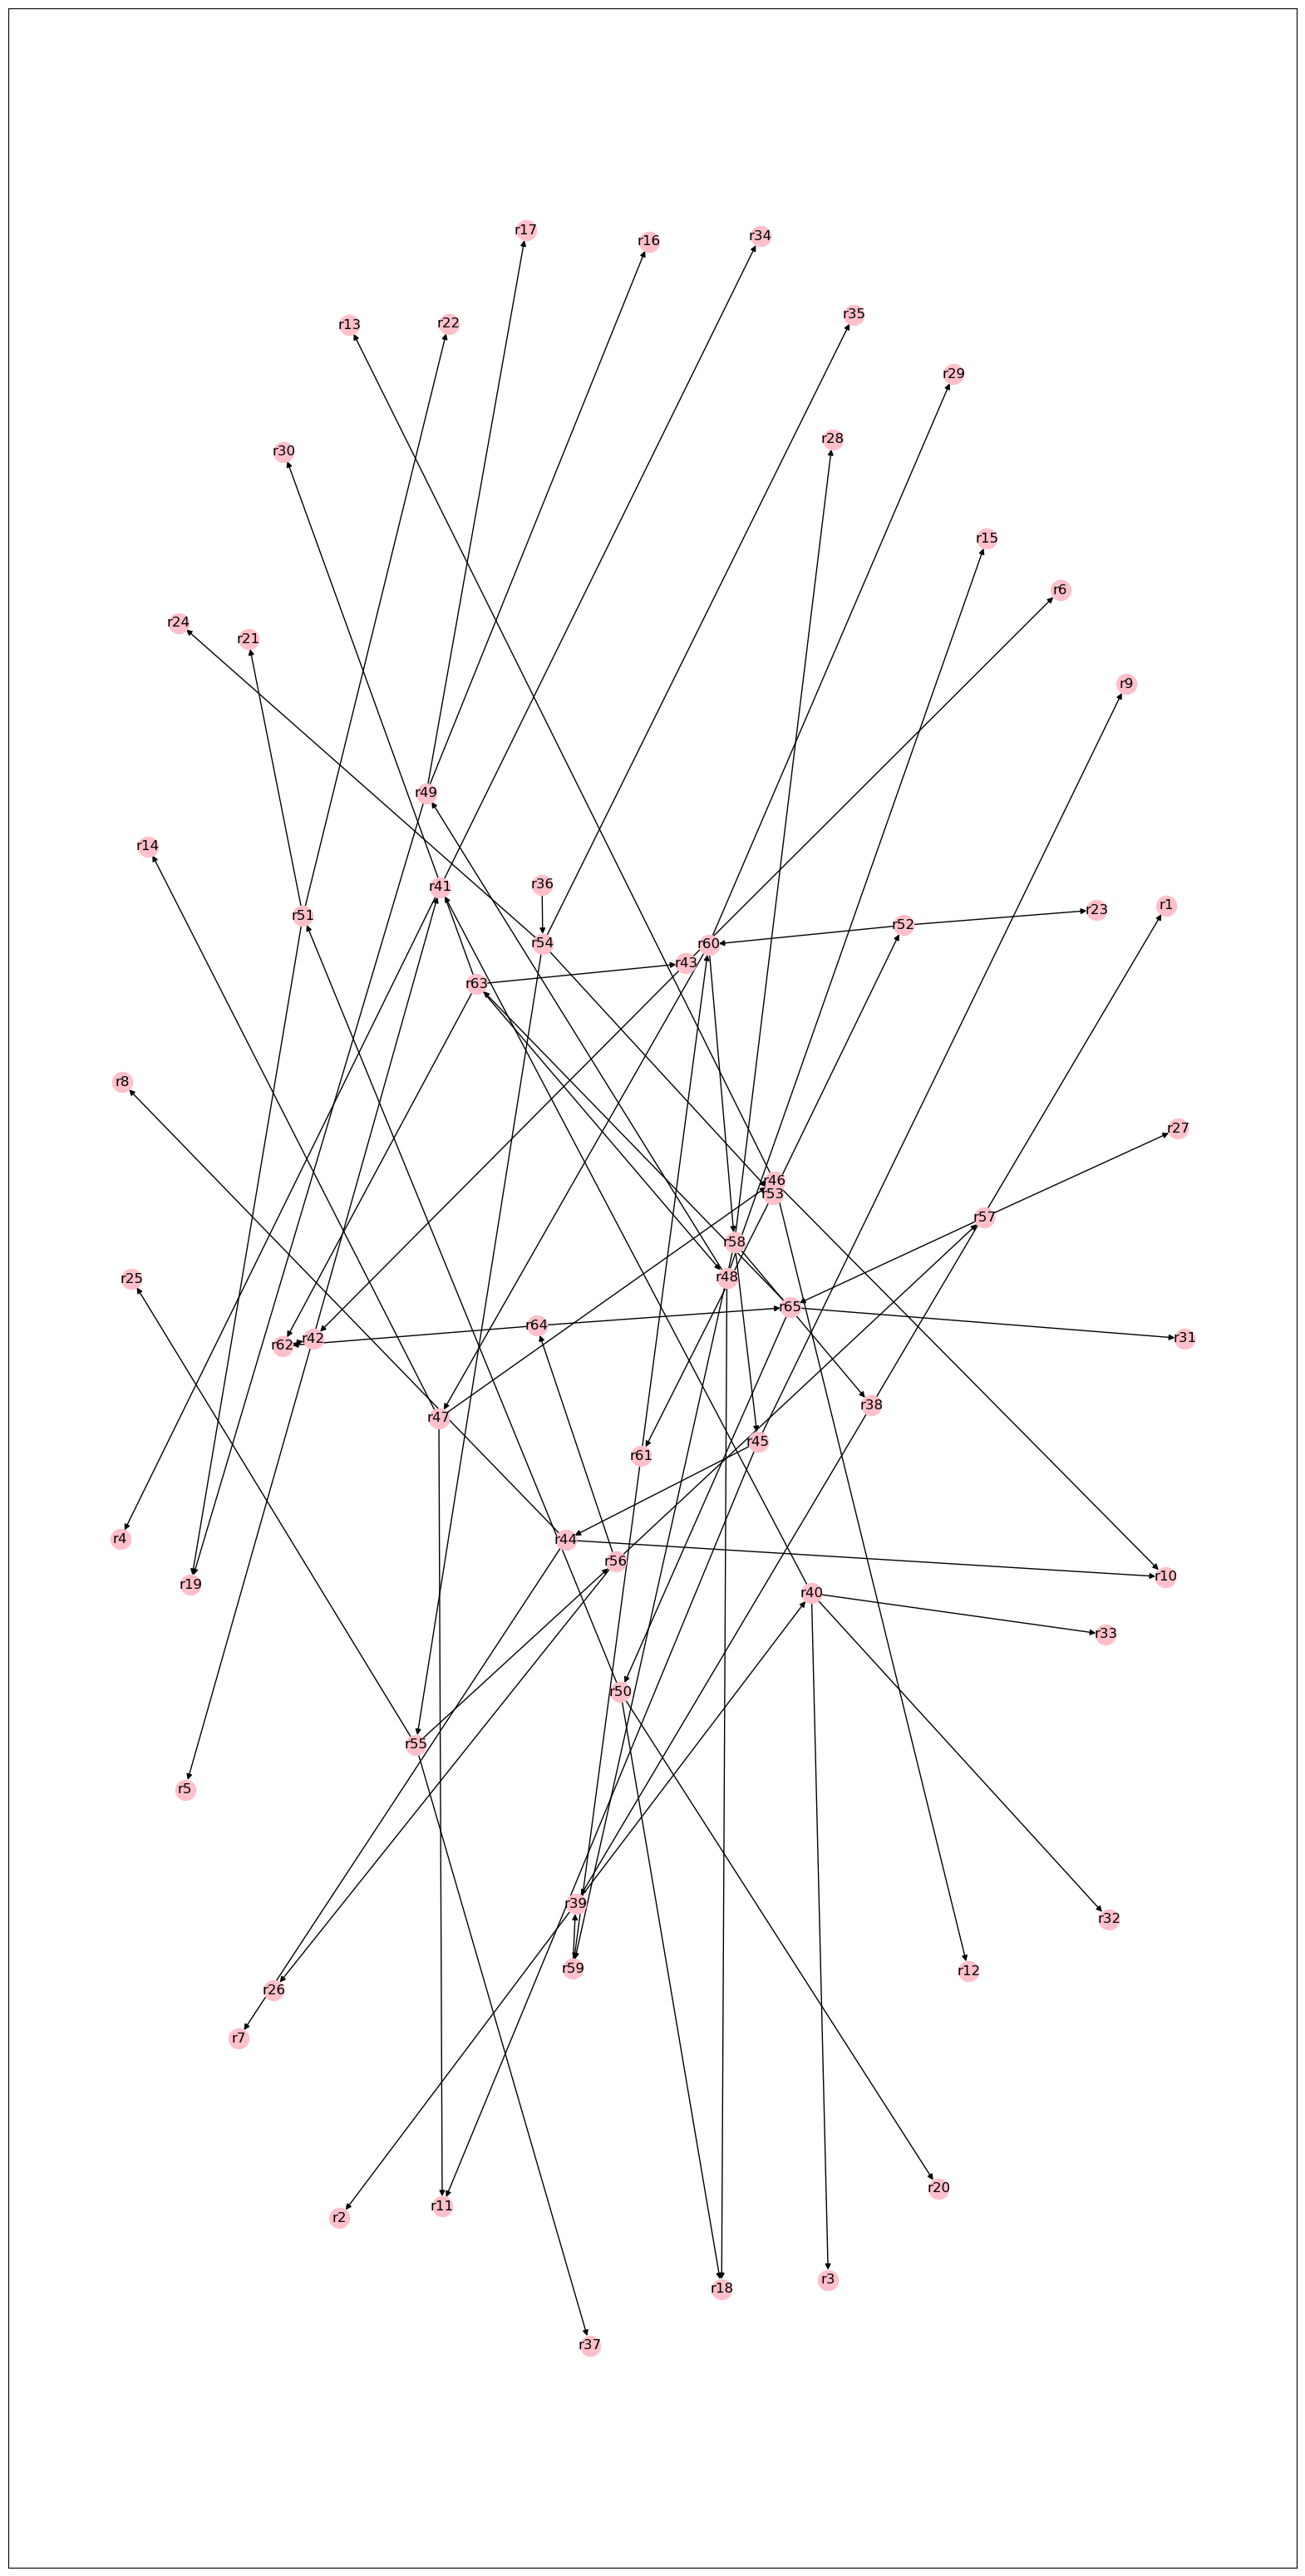

In [18]:
figures = []
plt.figure(figsize=(20,40))
G = nx.DiGraph()
G.add_edges_from(pair_of_smr)
nx.draw_networkx(G, arrows = True, node_color = 'pink')
figures.append(G)
plt.savefig('r.dag/1381(36).png')

## 2. <PyArgum 라이브러리를 이용한 동적 베이지안 네트워크 구현>

###   1) unStationary dBN (nsDBN)
 - DAG 유지, 확률변화 (CPT 변화 DBN만들기)

In [19]:
from datetime import datetime
now = datetime.now()

print("현재 : ", now)
print("현재 날짜 : ", now.date())
print("현재 시간 : ", now.time())
print("timestamp : ", now.timestamp())
print("년 : ", now.year)
print("월 : ", now.month)
print("일 : ", now.day)
print("시 : ", now.hour)
print("분 : ", now.minute)
print("초 : ", now.second)
print("마이크로초 : ", now.microsecond)
print("요일 : ", now.weekday())
print("문자열 변환 : ", now.strftime('%Y-%m-%d %H:%M:%S'))

현재 :  2023-11-23 19:19:58.318629
현재 날짜 :  2023-11-23
현재 시간 :  19:19:58.318629
timestamp :  1700734798.318629
년 :  2023
월 :  11
일 :  23
시 :  19
분 :  19
초 :  58
마이크로초 :  318629
요일 :  3
문자열 변환 :  2023-11-23 19:19:58


In [20]:
import pyAgrum as gum
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.lib.notebook as gnb

In [21]:
dag_dBN = gum.BayesNet('1381(36)')
dag_nodes = list(G.nodes)
dBN_nodes = []

for node in dag_nodes:
    globals()[node+'_0'] = dag_dBN.add(gum.LabelizedVariable(node+'_0',node+'_0',2))
    globals()[node+'_t'] = dag_dBN.add(gum.LabelizedVariable(node+'_t',node+'_t',2))
    dBN_nodes.append(node+'_0')
    dBN_nodes.append(node+'_t')

In [22]:
pair_of_self = [(node+'_0', node+'_t') for node in dag_nodes]
for link in pair_of_smr0:
    dag_dBN.addArc(*link)

print(dag_dBN)

for link in pair_of_smrt:
    dag_dBN.addArc(*link)

print(dag_dBN)

for link in pair_of_self:
    dag_dBN.addArc(*link)

BN{nodes: 130, arcs: 75, domainSize: 10^39.1339, dim: 216, mem: 3Ko 384o}
BN{nodes: 130, arcs: 150, domainSize: 10^39.1339, dim: 302, mem: 4Ko 736o}


In [23]:
for i in dBN_nodes:
    print(dag_dBN.cpt(i))


      ||  r46_0            |
r47_0 ||0        |1        |
------||---------|---------|
0     || 0.0000  | 0.0000  |
1     || 0.0000  | 0.0000  |


             ||  r46_t            |
r47_t |r46_0 ||0        |1        |
------|------||---------|---------|
0     |0     || 0.0000  | 0.0000  |
1     |0     || 0.0000  | 0.0000  |
0     |1     || 0.0000  | 0.0000  |
1     |1     || 0.0000  | 0.0000  |


             ||  r10_0            |
r46_0 |r44_0 ||0        |1        |
------|------||---------|---------|
0     |0     || 0.0000  | 0.0000  |
1     |0     || 0.0000  | 0.0000  |
0     |1     || 0.0000  | 0.0000  |
1     |1     || 0.0000  | 0.0000  |


                    ||  r10_t            |
r46_t |r44_t |r10_0 ||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.0000  | 0.0000  |
1     |0     |0     || 0.0000  | 0.0000  |
0     |1     |0     || 0.0000  | 0.0000  |
1     |1     |0     || 0.0000  | 0.0000  |
0     |0     |1     || 0.0000  | 0.0000  |


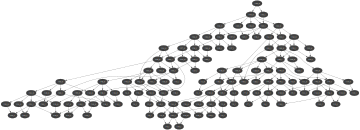

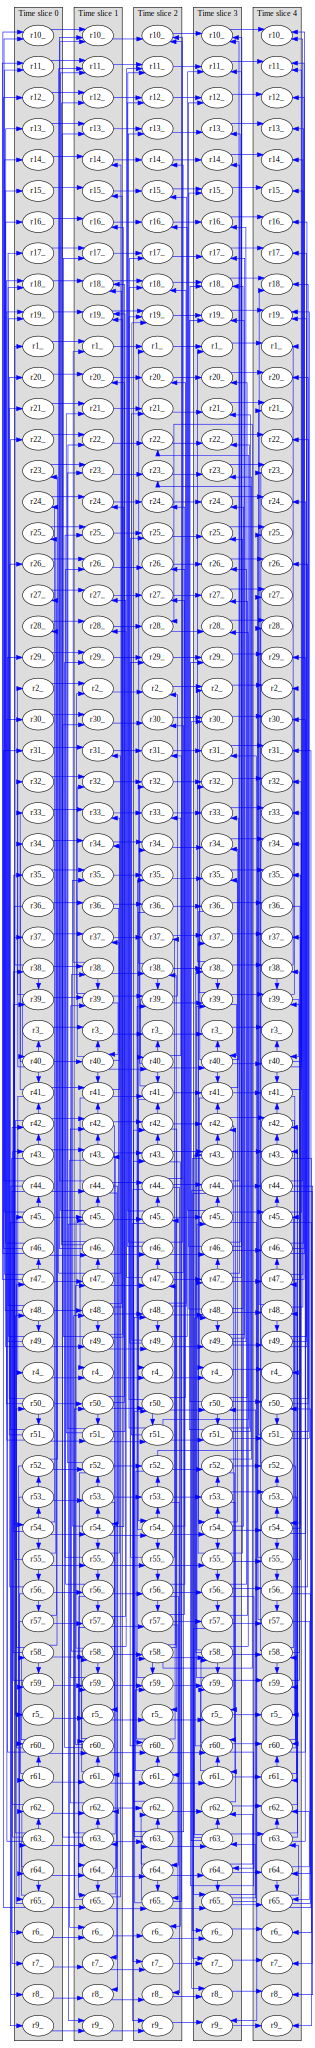

In [24]:
T = 5

gnb.showBN(dag_dBN)

ftts_dbn = gdyn.unroll2TBN(dag_dBN, T)
gdyn.showTimeSlices(ftts_dbn, size="30")

In [25]:
ftts_dbn_nodes = ftts_dbn.names()
ts_0 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) == 0)])
ts_1 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(1, 2))])
ts_2 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(2, 3))])
ts_3 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(3, 4))])
ts_4 = sorted([e for e in ftts_dbn_nodes
          if (int(e.split('_')[1]) in range(4, 5))])

### 2) CPT timeslice별 리스트 작성 (CPT_calculation_template_EXP.xlsx 템플릿 이용)

####  (1) CPT를 엑셀 템플릿으로 계산할 때는 총 400초의 simulation time을 100초 단위로 끊어 네 구간에서 계산
####  (2) pyAgrum을 이용한 dBN을 만들 때에는 400초를 8구간으로 나누어 생각함. (50s로 단위로 끊은 후 두 구간씩 같은 list를 사용한다.)

In [26]:
cpt_0 = [[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[1, 0],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0044,0.9956,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000]]

cpt_1= [[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.6148,0.3852,0.0000,1.0000,0.6148,0.3852,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.3478,0.6522,0.0000,1.0000,0.3478,0.6522,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4770,0.5230,0.0000,1.0000,0.4770,0.5230,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000],[0.4187,0.5813,0.0000,1.0000,0.4187,0.5813,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.4458,0.5542,0.0000,1.0000,0.4458,0.5542,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.6978,0.3022,0.0000,1.0000,0.6978,0.3022,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000],[0.8197,0.1803,0.0000,1.0000,0.8197,0.1803,0.0000,1.0000],[0.5883,0.4117,0.0000,1.0000,0.5883,0.4117,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.7809,0.2191,0.4491,0.5509,0.5579,0.4421,0.0071,0.9929,0.7809,0.2191,0.4421,0.5579,0.5509,0.4491,0.0000,1.0000],[0.5843,0.4157,0.0000,1.0000,0.5843,0.4157,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.5466,0.4534,0.0000,1.0000,0.5466,0.4534,0.0000,1.0000],[0.7142,0.2858,0.4573,0.5427,0.5504,0.4496,0.0077,0.9923,0.7142,0.2858,0.4496,0.5504,0.5427,0.4573,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000],[0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000]]

cpt_2 = [[0.4793,0.5207,0.2742,0.7258,0.7258,0.2742,0.0000,1.0000,0.4793,0.5207,0.2742,0.7258,0.7258,0.2742,0.0000,1.0000],[0.5492,0.4508,0.4658,0.5342,0.5342,0.4658,0.0000,1.0000,0.5492,0.4508,0.4658,0.5342,0.5342,0.4658,0.0000,1.0000],[0.4485,0.5515,0.0000,1.0000,0.4485,0.5515,0.0000,1.0000],[0.5167,0.4833,0.0000,1.0000,0.5167,0.4833,0.0000,1.0000],[0.5753,0.4247,0.0000,1.0000,0.5753,0.4247,0.0000,1.0000],[0.3520,0.6480,0.0000,1.0000,0.3520,0.6480,0.0000,1.0000],[0.3323,0.6677,0.0000,1.0000,0.3323,0.6677,0.0000,1.0000],[0.2871,0.7129,0.0000,1.0000,0.2871,0.7129,0.0000,1.0000],[0.5537,0.4463,0.4853,0.5147,0.5147,0.4853,0.0000,1.0000,0.5537,0.4463,0.4853,0.5147,0.5147,0.4853,0.0000,1.0000],[0.5412,0.4588,0.6917,0.3083,0.3083,0.6917,0.0000,1.0000,0.5412,0.4588,0.6917,0.3083,0.3083,0.6917,0.0000,1.0000],[0.4478,0.5522,0.0000,1.0000,0.4478,0.5522,0.0000,1.0000],[0.5229,0.4771,0.0000,1.0000,0.5229,0.4771,0.0000,1.0000],[0.5307,0.4693,0.0000,1.0000,0.5307,0.4693,0.0000,1.0000],[0.4021,0.5979,0.0000,1.0000,0.4021,0.5979,0.0000,1.0000],[0.7104,0.2896,0.0000,1.0000,0.7104,0.2896,0.0000,1.0000],[1.0000,0.0000,0.6311,0.3689,0.3689,0.6311,0.0000,1.0000],[1.0000,0.0000,0.5684,0.4316,0.4316,0.5684,0.0000,1.0000],[1.0000,0.0000,0.5087,0.4913,0.4913,0.5087,0.0000,1.0000],[0.6417,0.3583,0.0000,1.0000,0.6417,0.3583,0.0000,1.0000],[0.3854,0.6146,0.0000,1.0000,0.3854,0.6146,0.0000,1.0000],[1.0000,0.0000,0.5018,0.4982,0.4982,0.5018,0.0000,1.0000],[0.4694,0.5306,0.0000,1.0000,0.4694,0.5306,0.0000,1.0000],[0.3664,0.6336,0.0000,1.0000,0.3664,0.6336,0.0000,1.0000],[0.5761,0.4239,0.0000,1.0000,0.5761,0.4239,0.0000,1.0000],[0.4383,0.5617,0.0000,1.0000,0.4383,0.5617,0.0000,1.0000],[0.3853,0.6147,0.0000,1.0000,0.3853,0.6147,0.0000,1.0000],[0.3512,0.6488,0.0000,1.0000,0.3512,0.6488,0.0000,1.0000],[1.0000,0.0000,0.5295,0.4705,0.4705,0.5295,0.0000,1.0000],[0.5000,0.5000,0.0000,1.0000],[1.0000,0.0000,0.5390,0.4610,0.4610,0.5390,0.0000,1.0000],[0.6982,0.3018,0.0000,1.0000,0.6982,0.3018,0.0000,1.0000],[0.9121,0.0879,0.4702,0.5298,0.5298,0.4702,0.0000,1.0000,0.9121,0.0879,0.4702,0.5298,0.5298,0.4702,0.0000,1.0000],[0.3610,0.6390,0.0000,1.0000,0.3610,0.6390,0.0000,1.0000],[0.6042,0.3958,0.0000,1.0000,0.6042,0.3958,0.0000,1.0000],[0.6847,0.3153,0.5395,0.4605,0.4605,0.5395,0.0000,1.0000,0.6847,0.3153,0.5395,0.4605,0.4605,0.5395,0.0000,1.0000],[0.7363,0.2637,0.5281,0.4719,0.4719,0.5281,0.0000,1.0000,0.7363,0.2637,0.5281,0.4719,0.4719,0.5281,0.0000,1.0000],[0.5717,0.4283,0.0000,1.0000,0.5717,0.4283,0.0000,1.0000],[0.4974,0.5026,0.0000,1.0000,0.4974,0.5026,0.0000,1.0000],[0.6953,0.3047,0.0000,1.0000,0.6953,0.3047,0.0000,1.0000],[0.7099,0.2901,0.0000,1.0000,0.7099,0.2901,0.0000,1.0000],[0.8828,0.1172,0.0000,1.0000,0.8828,0.1172,0.0000,1.0000],[0.6586,0.3414,0.0000,1.0000,0.6586,0.3414,0.0000,1.0000],[0.4684,0.5316,0.0000,1.0000,0.4684,0.5316,0.0000,1.0000],[0.3650,0.6350,0.0000,1.0000,0.3650,0.6350,0.0000,1.0000],[0.7882,0.2118,0.0000,1.0000,0.7882,0.2118,0.0000,1.0000],[0.6195,0.3805,0.0000,1.0000,0.6195,0.3805,0.0000,1.0000],[1.0000,0.0000,0.4279,0.5721,0.5721,0.4279,0.0000,1.0000],[1.0000,0.0000,0.5171,0.4829,0.4829,0.5171,0.0000,1.0000],[1.0000,0.0000,0.6440,0.3560,0.3560,0.6440,0.0000,1.0000],[1.0000,0.0000,0.5685,0.4315,0.4315,0.5685,0.0000,1.0000],[1.0000,0.0000,0.4505,0.5495,0.5495,0.4505,0.0000,1.0000],[1.0000,0.0000,0.3955,0.6045,0.6045,0.3955,0.0000,1.0000],[0.8556,0.1444,0.0000,1.0000,0.8556,0.1444,0.0000,1.0000],[0.9654,0.0346,0.6378,0.3622,0.3622,0.6378,0.0000,1.0000,0.9654,0.0346,0.6378,0.3622,0.3622,0.6378,0.0000,1.0000],[0.4627,0.5373,0.0000,1.0000,0.4627,0.5373,0.0000,1.0000],[1.0000,0.0000,0.5921,0.4079,0.6726,0.3274,0.2647,0.7353,1.0000,0.0000,0.3274,0.6726,0.4079,0.5921,0.0000,1.0000],[1.0000,0.0000,0.5025,0.4975,0.4975,0.5025,0.0000,1.0000],[0.8000,0.2000,0.7010,0.2990,0.2990,0.7010,0.0000,1.0000,0.8000,0.2000,0.7010,0.2990,0.2990,0.7010,0.0000,1.0000],[0.7455,0.2545,0.0000,1.0000,0.7455,0.2545,0.0000,1.0000],[1.0000,0.0000,0.4488,0.5512,0.5512,0.4488,0.0000,1.0000],[1.0000,0.0000,0.5792,0.4208,0.6628,0.3372,0.2421,0.7579,1.0000,0.0000,0.3372,0.6628,0.4208,0.5792,0.0000,1.0000],[0.4309,0.5691,0.0000,1.0000,0.4309,0.5691,0.0000,1.0000],[0.5477,0.4523,0.0000,1.0000,0.5477,0.4523,0.0000,1.0000],[0.3408,0.6592,0.0000,1.0000,0.3408,0.6592,0.0000,1.0000],[0.3700,0.6300,0.0000,1.0000,0.3700,0.6300,0.0000,1.0000]]

cpt_3 = [[1.0000,0.0000,0.7275,0.2725,0.8705,0.1295,0.5980,0.4020,0.4020,0.5980,0.1295,0.8705,0.2725,0.7275,0.0000,1.0000],[1.0000,0.0000,0.7830,0.2170,0.7574,0.2426,0.5404,0.4596,0.4596,0.5404,0.2426,0.7574,0.2170,0.7830,0.0000,1.0000],[1.0000,0.0000,0.6616,0.3384,0.3384,0.6616,0.0000,1.0000],[1.0000,0.0000,0.6415,0.3585,0.3585,0.6415,0.0000,1.0000],[1.0000,0.0000,0.6363,0.3637,0.3637,0.6363,0.0000,1.0000],[1.0000,0.0000,0.5481,0.4519,0.4519,0.5481,0.0000,1.0000],[1.0000,0.0000,0.5547,0.4453,0.4453,0.5547,0.0000,1.0000],[1.0000,0.0000,0.6044,0.3956,0.3956,0.6044,0.0000,1.0000],[1.0000,0.0000,0.7148,0.2852,0.7781,0.2219,0.4929,0.5071,0.5071,0.4929,0.2219,0.7781,0.2852,0.7148,0.0000,1.0000],[1.0000,0.0000,0.8271,0.1729,0.7092,0.2908,0.5363,0.4637,0.4637,0.5363,0.2908,0.7092,0.1729,0.8271,0.0000,1.0000],[1.0000,0.0000,0.6343,0.3657,0.3657,0.6343,0.0000,1.0000],[1.0000,0.0000,0.6354,0.3646,0.3646,0.6354,0.0000,1.0000],[1.0000,0.0000,0.6117,0.3883,0.3883,0.6117,0.0000,1.0000],[1.0000,0.0000,0.6552,0.3448,0.3448,0.6552,0.0000,1.0000],[1.0000,0.0000,0.6068,0.3932,0.3932,0.6068,0.0000,1.0000],[1.0000,0.0000,0.6952,0.3048,0.3048,0.6952,0.0000,1.0000],[1.0000,0.0000,0.7073,0.2927,0.2927,0.7073,0.0000,1.0000],[1.0000,0.0000,0.6987,0.3013,0.3013,0.6987,0.0000,1.0000],[1.0000,0.0000,0.7035,0.2965,0.2965,0.7035,0.0000,1.0000],[1.0000,0.0000,0.6224,0.3776,0.3776,0.6224,0.0000,1.0000],[1.0000,0.0000,0.7206,0.2794,0.2794,0.7206,0.0000,1.0000],[1.0000,0.0000,0.6142,0.3858,0.3858,0.6142,0.0000,1.0000],[1.0000,0.0000,0.6022,0.3978,0.3978,0.6022,0.0000,1.0000],[1.0000,0.0000,0.7394,0.2606,0.2606,0.7394,0.0000,1.0000],[1.0000,0.0000,0.5422,0.4578,0.4578,0.5422,0.0000,1.0000],[1.0000,0.0000,0.5708,0.4292,0.4292,0.5708,0.0000,1.0000],[1.0000,0.0000,0.5785,0.4215,0.4215,0.5785,0.0000,1.0000],[1.0000,0.0000,0.6924,0.3076,0.3076,0.6924,0.0000,1.0000],[0.6667,0.3333,0.0000,1.0000],[1.0000,0.0000,0.7032,0.2968,0.2968,0.7032,0.0000,1.0000],[1.0000,0.0000,0.5686,0.4314,0.4314,0.5686,0.0000,1.0000],[1.0000,0.0000,0.6401,0.3599,0.7391,0.2609,0.3792,0.6208,0.6208,0.3792,0.2609,0.7391,0.3599,0.6401,0.0000,1.0000],[1.0000,0.0000,0.5501,0.4499,0.4499,0.5501,0.0000,1.0000],[1.0000,0.0000,0.5223,0.4777,0.4777,0.5223,0.0000,1.0000],[1.0000,0.0000,0.7062,0.2938,0.6797,0.3203,0.3859,0.6141,0.6141,0.3859,0.3203,0.6797,0.2938,0.7062,0.0000,1.0000],[1.0000,0.0000,0.7248,0.2752,0.7293,0.2707,0.4541,0.5459,0.5459,0.4541,0.2707,0.7293,0.2752,0.7248,0.0000,1.0000],[1.0000,0.0000,0.5973,0.4027,0.4027,0.5973,0.0000,1.0000],[1.0000,0.0000,0.5633,0.4367,0.4367,0.5633,0.0000,1.0000],[1.0000,0.0000,0.5616,0.4384,0.4384,0.5616,0.0000,1.0000],[1.0000,0.0000,0.6195,0.3805,0.3805,0.6195,0.0000,1.0000],[1.0000,0.0000,0.6279,0.3721,0.3721,0.6279,0.0000,1.0000],[1.0000,0.0000,0.5319,0.4681,0.4681,0.5319,0.0000,1.0000],[1.0000,0.0000,0.5400,0.4600,0.4600,0.5400,0.0000,1.0000],[1.0000,0.0000,0.5628,0.4372,0.4372,0.5628,0.0000,1.0000],[1.0000,0.0000,0.6189,0.3811,0.3811,0.6189,0.0000,1.0000],[1.0000,0.0000,0.6182,0.3818,0.3818,0.6182,0.0000,1.0000],[1.0000,0.0000,0.5827,0.4173,0.4173,0.5827,0.0000,1.0000],[1.0000,0.0000,0.5623,0.4377,0.4377,0.5623,0.0000,1.0000],[1.0000,0.0000,0.5365,0.4635,0.4635,0.5365,0.0000,1.0000],[1.0000,0.0000,0.5515,0.4485,0.4485,0.5515,0.0000,1.0000],[1.0000,0.0000,0.5714,0.4286,0.4286,0.5714,0.0000,1.0000],[1.0000,0.0000,0.5886,0.4114,0.4114,0.5886,0.0000,1.0000],[1.0000,0.0000,0.5769,0.4231,0.4231,0.5769,0.0000,1.0000],[1.0000,0.0000,0.7391,0.2609,0.7281,0.2719,0.4672,0.5328,0.5328,0.4672,0.2719,0.7281,0.2609,0.7391,0.0000,1.0000],[1.0000,0.0000,0.6100,0.3900,0.3900,0.6100,0.0000,1.0000],[1.0000,0.0000,0.6828,0.3172,0.7454,0.2546,0.4282,0.5718,0.5718,0.4282,0.2546,0.7454,0.3172,0.6828,0.0000,1.0000],[1.0000,0.0000,0.6364,0.3636,0.3636,0.6364,0.0000,1.0000],[1.0000,0.0000,0.8094,0.1906,0.7214,0.2786,0.5308,0.4692,0.4692,0.5308,0.2786,0.7214,0.1906,0.8094,0.0000,1.0000],[1.0000,0.0000,0.5749,0.4251,0.4251,0.5749,0.0000,1.0000],[1.0000,0.0000,0.6318,0.3682,0.3682,0.6318,0.0000,1.0000],[1.0000,0.0000,0.6827,0.3173,0.7457,0.2543,0.4284,0.5716,0.5716,0.4284,0.2543,0.7457,0.3173,0.6827,0.0000,1.0000],[1.0000,0.0000,0.6040,0.3960,0.3960,0.6040,0.0000,1.0000],[1.0000,0.0000,0.7153,0.2847,0.2847,0.7153,0.0000,1.0000],[1.0000,0.0000,0.5631,0.4369,0.4369,0.5631,0.0000,1.0000],[1.0000,0.0000,0.5605,0.4395,0.4395,0.5605,0.0000,1.0000]]

cpt_4 = [[1.0000,0.0000,0.7419,0.2581,0.8602,0.1398,0.6021,0.3979,0.3979,0.6021,0.1398,0.8602,0.2581,0.7419,0.0000,1.0000],[1.0000,0.0000,0.7846,0.2154,0.7448,0.2552,0.5294,0.4706,0.4706,0.5294,0.2552,0.7448,0.2154,0.7846,0.0000,1.0000],[1.0000,0.0000,0.7023,0.2977,0.2977,0.7023,0.0000,1.0000],[1.0000,0.0000,0.6625,0.3375,0.3375,0.6625,0.0000,1.0000],[1.0000,0.0000,0.6504,0.3496,0.3496,0.6504,0.0000,1.0000],[1.0000,0.0000,0.6454,0.3546,0.3546,0.6454,0.0000,1.0000],[1.0000,0.0000,0.6616,0.3384,0.3384,0.6616,0.0000,1.0000],[1.0000,0.0000,0.7077,0.2923,0.2923,0.7077,0.0000,1.0000],[1.0000,0.0000,0.7079,0.2921,0.7906,0.2094,0.4985,0.5015,0.5015,0.4985,0.2094,0.7906,0.2921,0.7079,0.0000,1.0000],[1.0000,0.0000,0.8095,0.1905,0.7363,0.2637,0.5458,0.4542,0.4542,0.5458,0.2637,0.7363,0.1905,0.8095,0.0000,1.0000],[1.0000,0.0000,0.6856,0.3144,0.3144,0.6856,0.0000,1.0000],[1.0000,0.0000,0.6583,0.3417,0.3417,0.6583,0.0000,1.0000],[1.0000,0.0000,0.6504,0.3496,0.3496,0.6504,0.0000,1.0000],[1.0000,0.0000,0.7131,0.2869,0.2869,0.7131,0.0000,1.0000],[1.0000,0.0000,0.6057,0.3943,0.3943,0.6057,0.0000,1.0000],[1.0000,0.0000,0.6581,0.3419,0.3419,0.6581,0.0000,1.0000],[1.0000,0.0000,0.6710,0.3290,0.3290,0.6710,0.0000,1.0000],[1.0000,0.0000,0.6617,0.3383,0.3383,0.6617,0.0000,1.0000],[1.0000,0.0000,0.6735,0.3265,0.3265,0.6735,0.0000,1.0000],[1.0000,0.0000,0.7015,0.2985,0.2985,0.7015,0.0000,1.0000],[1.0000,0.0000,0.6851,0.3149,0.3149,0.6851,0.0000,1.0000],[1.0000,0.0000,0.6698,0.3302,0.3302,0.6698,0.0000,1.0000],[1.0000,0.0000,0.6957,0.3043,0.3043,0.6957,0.0000,1.0000],[1.0000,0.0000,0.7053,0.2947,0.2947,0.7053,0.0000,1.0000],[1.0000,0.0000,0.6375,0.3625,0.3625,0.6375,0.0000,1.0000],[1.0000,0.0000,0.6701,0.3299,0.3299,0.6701,0.0000,1.0000],[1.0000,0.0000,0.6886,0.3114,0.3114,0.6886,0.0000,1.0000],[1.0000,0.0000,0.6551,0.3449,0.3449,0.6551,0.0000,1.0000],[0.7500,0.2500,0.0000,1.0000],[1.0000,0.0000,0.6666,0.3334,0.3334,0.6666,0.0000,1.0000],[1.0000,0.0000,0.5855,0.4145,0.4145,0.5855,0.0000,1.0000],[1.0000,0.0000,0.6463,0.3537,0.7436,0.2564,0.3899,0.6101,0.6101,0.3899,0.2564,0.7436,0.3537,0.6463,0.0000,1.0000],[1.0000,0.0000,0.6691,0.3309,0.3309,0.6691,0.0000,1.0000],[1.0000,0.0000,0.5788,0.4212,0.4212,0.5788,0.0000,1.0000],[1.0000,0.0000,0.7412,0.2588,0.7178,0.2822,0.4590,0.5410,0.5410,0.4590,0.2822,0.7178,0.2588,0.7412,0.0000,1.0000],[1.0000,0.0000,0.7421,0.2579,0.7463,0.2537,0.4883,0.5117,0.5117,0.4883,0.2537,0.7463,0.2579,0.7421,0.0000,1.0000],[1.0000,0.0000,0.6333,0.3667,0.3667,0.6333,0.0000,1.0000],[1.0000,0.0000,0.6323,0.3677,0.3677,0.6323,0.0000,1.0000],[1.0000,0.0000,0.5805,0.4195,0.4195,0.5805,0.0000,1.0000],[1.0000,0.0000,0.6164,0.3836,0.3836,0.6164,0.0000,1.0000],[1.0000,0.0000,0.5874,0.4126,0.4126,0.5874,0.0000,1.0000],[1.0000,0.0000,0.5713,0.4287,0.4287,0.5713,0.0000,1.0000],[1.0000,0.0000,0.6274,0.3726,0.3726,0.6274,0.0000,1.0000],[1.0000,0.0000,0.6724,0.3276,0.3276,0.6724,0.0000,1.0000],[1.0000,0.0000,0.5990,0.4010,0.4010,0.5990,0.0000,1.0000],[1.0000,0.0000,0.6343,0.3657,0.3657,0.6343,0.0000,1.0000],[1.0000,0.0000,0.5409,0.4591,0.4591,0.5409,0.0000,1.0000],[1.0000,0.0000,0.5202,0.4798,0.4798,0.5202,0.0000,1.0000],[1.0000,0.0000,0.4941,0.5059,0.5059,0.4941,0.0000,1.0000],[1.0000,0.0000,0.5092,0.4908,0.4908,0.5092,0.0000,1.0000],[1.0000,0.0000,0.5294,0.4706,0.4706,0.5294,0.0000,1.0000],[1.0000,0.0000,0.5469,0.4531,0.4531,0.5469,0.0000,1.0000],[1.0000,0.0000,0.5586,0.4414,0.4414,0.5586,0.0000,1.0000],[1.0000,0.0000,0.7185,0.2815,0.7067,0.2933,0.4252,0.5748,0.5748,0.4252,0.2933,0.7067,0.2815,0.7185,0.0000,1.0000],[1.0000,0.0000,0.6703,0.3297,0.3297,0.6703,0.0000,1.0000],[1.0000,0.0000,0.6600,0.3400,0.7272,0.2728,0.3872,0.6128,0.6128,0.3872,0.2728,0.7272,0.3400,0.6600,0.0000,1.0000],[1.0000,0.0000,0.5963,0.4037,0.4037,0.5963,0.0000,1.0000],[1.0000,0.0000,0.7991,0.2009,0.7062,0.2938,0.5053,0.4947,0.4947,0.5053,0.2938,0.7062,0.2009,0.7991,0.0000,1.0000],[1.0000,0.0000,0.5779,0.4221,0.4221,0.5779,0.0000,1.0000],[1.0000,0.0000,0.5914,0.4086,0.4086,0.5914,0.0000,1.0000],[1.0000,0.0000,0.6599,0.3401,0.7275,0.2725,0.3874,0.6126,0.6126,0.3874,0.2725,0.7275,0.3401,0.6599,0.0000,1.0000],[1.0000,0.0000,0.6731,0.3269,0.3269,0.6731,0.0000,1.0000],[1.0000,0.0000,0.7073,0.2927,0.2927,0.7073,0.0000,1.0000],[1.0000,0.0000,0.6753,0.3247,0.3247,0.6753,0.0000,1.0000],[1.0000,0.0000,0.6534,0.3466,0.3466,0.6534,0.0000,1.0000]]


In [27]:
for i in range(len(ts_0)):
    ftts_dbn.cpt(ts_0[i]).fillWith(cpt_0[i])

In [28]:
for n in range(65):
    for i in range(1*n, 1*(n+1)):
        ftts_dbn.cpt(ts_1[i]).fillWith(cpt_1[n])

for n in range(65):
    for i in range(1*n, 1*(n+1)):
        ftts_dbn.cpt(ts_2[i]).fillWith(cpt_2[n])
        ftts_dbn.cpt(ts_3[i]).fillWith(cpt_3[n])
        ftts_dbn.cpt(ts_4[i]).fillWith(cpt_4[n])

In [29]:
il = gum.LazyPropagation(ftts_dbn)
iv = gum.VariableElimination(ftts_dbn)

In [30]:
iv.setEvidence({'r36_0':0, 'r36_1':0, 'r36_2':0, 'r36_3':0, 'r36_4':0})


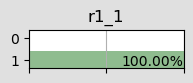
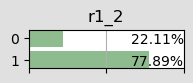
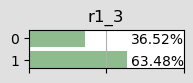
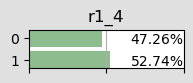
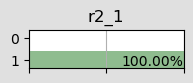
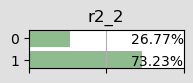
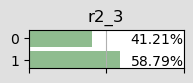
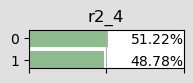
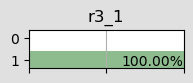
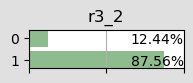
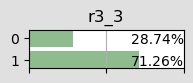
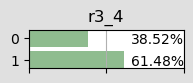
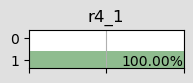
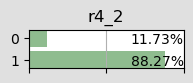
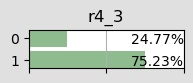
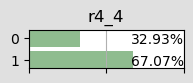
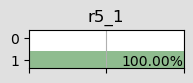
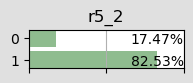
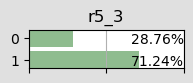
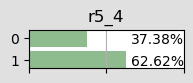
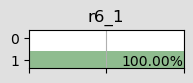
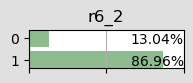
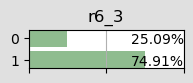
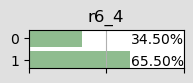
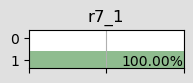
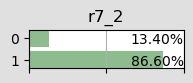
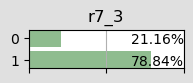
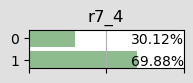
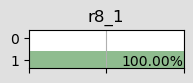
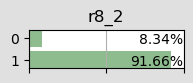
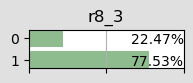
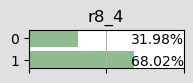
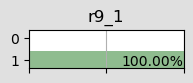
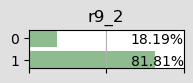
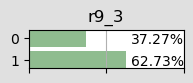
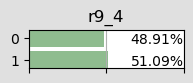
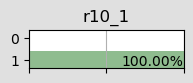
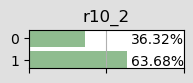
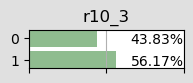
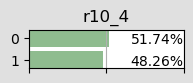
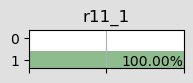
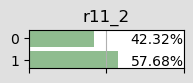
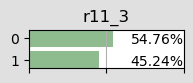
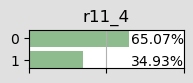
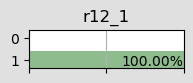
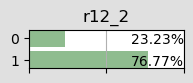
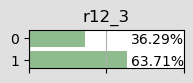
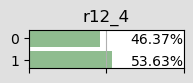
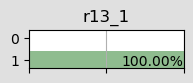
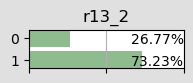
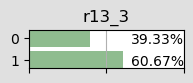
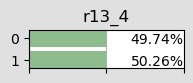
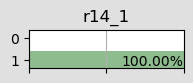
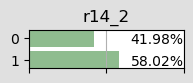
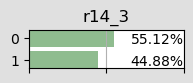
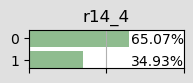
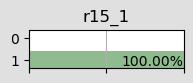
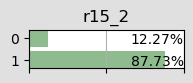
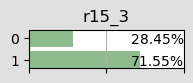
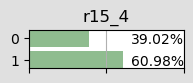
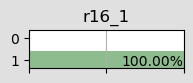
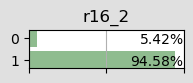
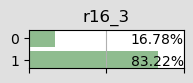
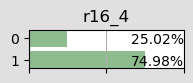
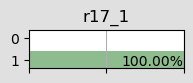
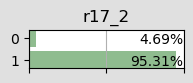
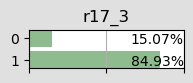
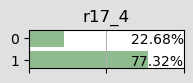
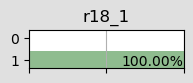
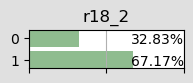
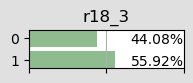
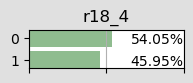
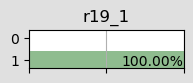
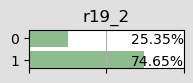
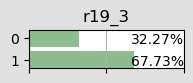
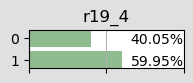
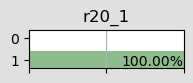
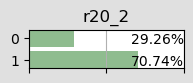
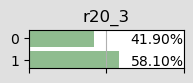
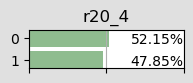
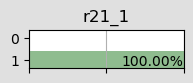
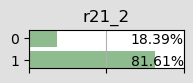
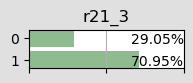
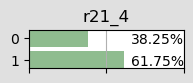
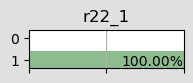
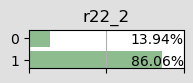
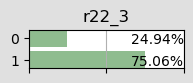
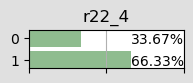
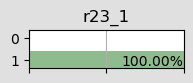
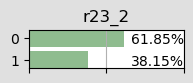
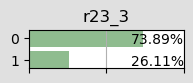
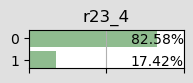
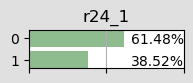
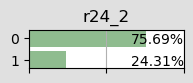
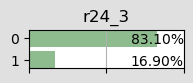
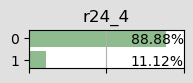
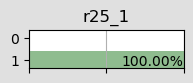
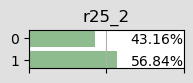
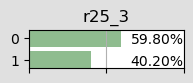
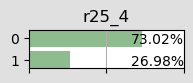
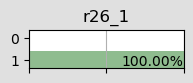
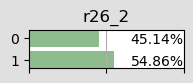
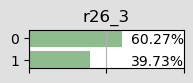
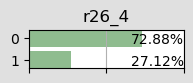
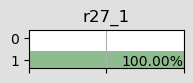
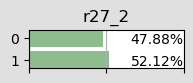
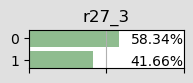
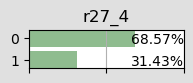
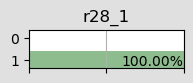
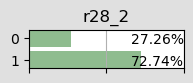
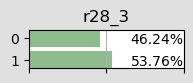
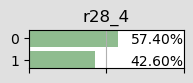
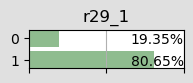
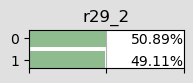
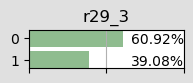
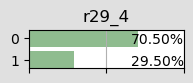
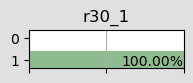
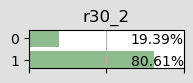
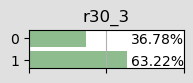
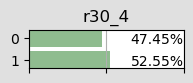
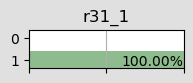
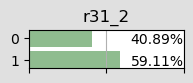
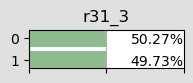
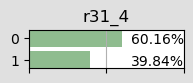
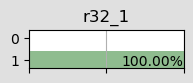
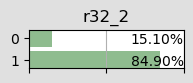
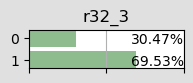
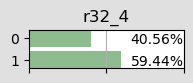
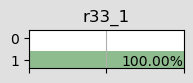
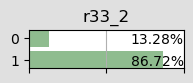
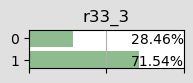
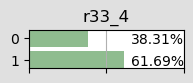
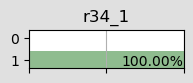
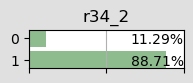
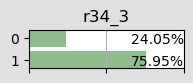
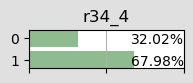
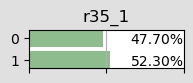
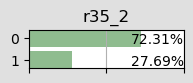
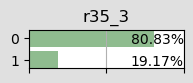
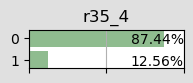
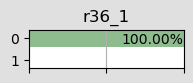
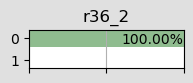
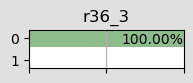
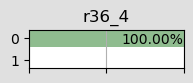
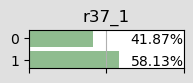
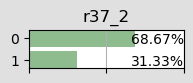
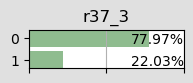
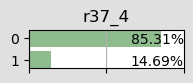
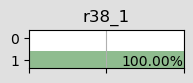
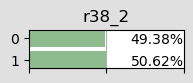
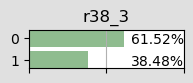
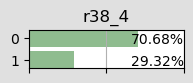
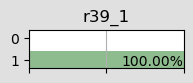
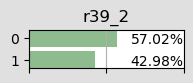
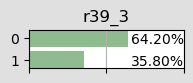
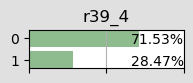
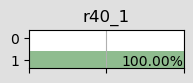
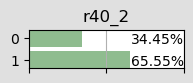
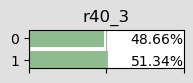
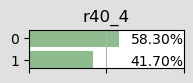
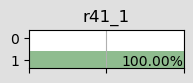
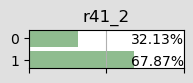
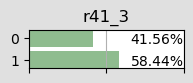
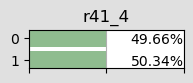
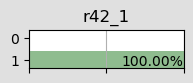
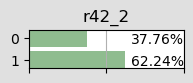
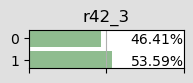
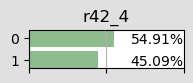
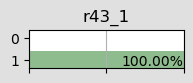
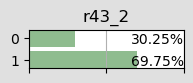
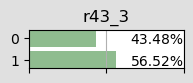
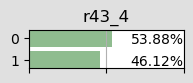
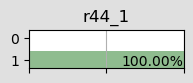
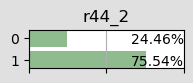
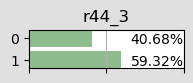
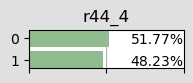
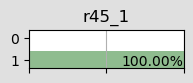
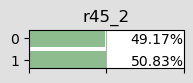
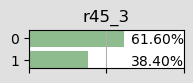
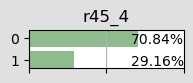
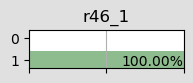
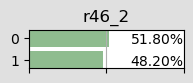
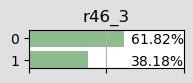
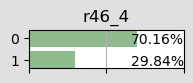
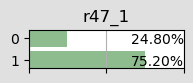
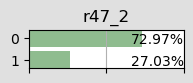
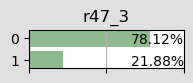
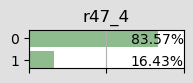
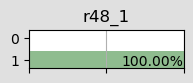
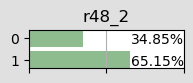
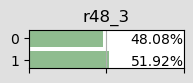
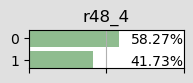
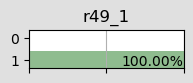
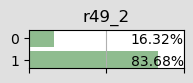
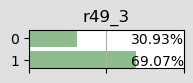
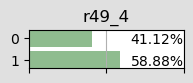
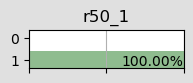
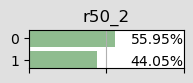
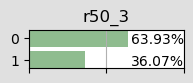
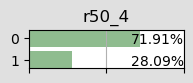
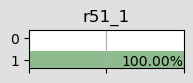
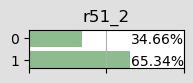
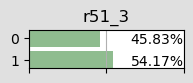
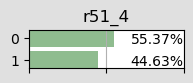
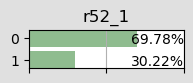
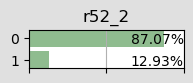
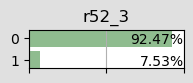
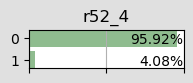
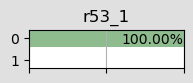
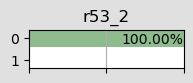
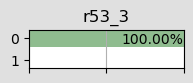
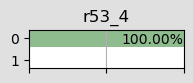
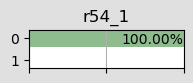
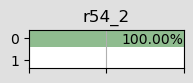
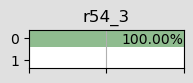
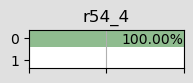
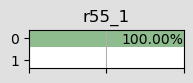
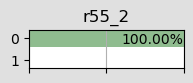
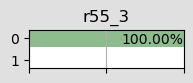
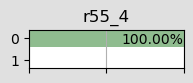
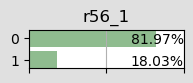
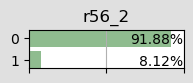
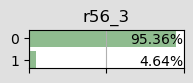
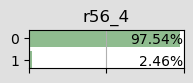
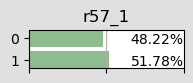
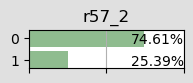
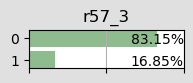
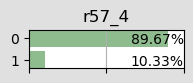
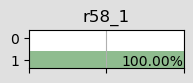
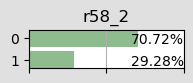
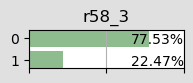
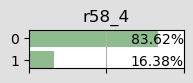
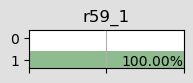
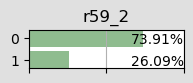
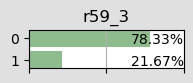
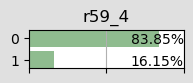
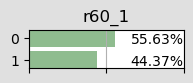
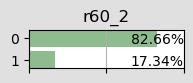
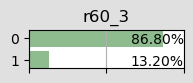
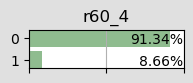
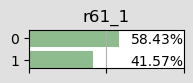
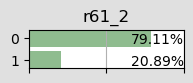
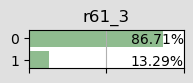
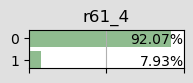
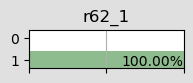
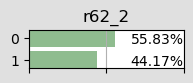
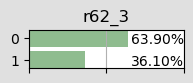
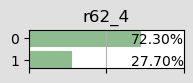
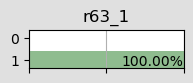
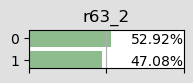
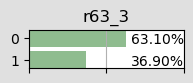
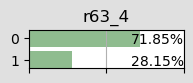
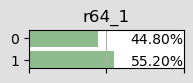
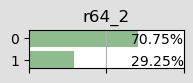
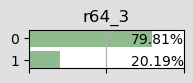
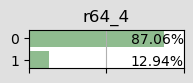
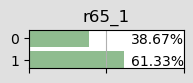
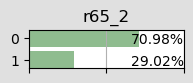
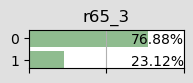
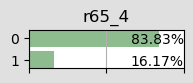

In [31]:
gnb.flow.clear()
for j in range(1,66):
    for i in [1, 2, 3, 4]:
        gnb.flow.add_html(gnb.getPosterior(ftts_dbn, target = "r"+str(j)+"_{}".format(i), evs={'r36_0':0, 'r36_1':0, 'r36_2':0, 'r36_3':0, 'r36_4':0}), "$P(a{})$".format(i))
gnb.flow.display()

In [32]:
now = datetime.now()

print("현재 : ", now)
print("현재 날짜 : ", now.date())
print("현재 시간 : ", now.time())
print("timestamp : ", now.timestamp())
print("년 : ", now.year)
print("월 : ", now.month)
print("일 : ", now.day)
print("시 : ", now.hour)
print("분 : ", now.minute)
print("초 : ", now.second)
print("마이크로초 : ", now.microsecond)
print("요일 : ", now.weekday())
print("문자열 변환 : ", now.strftime('%Y-%m-%d %H:%M:%S'))

현재 :  2023-11-23 19:20:11.269486
현재 날짜 :  2023-11-23
현재 시간 :  19:20:11.269486
timestamp :  1700734811.269486
년 :  2023
월 :  11
일 :  23
시 :  19
분 :  20
초 :  11
마이크로초 :  269486
요일 :  3
문자열 변환 :  2023-11-23 19:20:11


In [33]:
ftts_dbn_rooms =[e.split('_')[0]+('_') for e in ftts_dbn_nodes]

plt.rcParams['figure.figsize'] = (10, 2)
gdyn.plotFollowUnrolled(ftts_dbn_rooms,ftts_dbn,T=8,evs={'r36_0':0, 'r36_1':0, 'r36_2':0, 'r36_3':0, 'r36_4':0, 'r36_5':0, 'r36_6':0, 'r36_7':0 })

for node in dBN_nodes:
    dag_dBN.cpt(node)
    print(dag_dBN.cpt(node))

dag_dBN.cpt("r1_0").fillWith([0.74, 0.26, 0, 1])


dag_dBN.cpt("r53_0").names # 부모노드를 출력한다. 조건부확률의 조건


dag_dBN.cpt("r38_0").names


gnb.flow.clear()
for i in range(T):
    gnb.flow.add_html(gnb.getPosterior(unroll_dBN, target = "r1_{}".format(i), evs={}), "$P(a{})$".format(i))
gnb.flow.display()

sorted(ftts_dbn.names())

In [34]:
ftts_dbn.cpt('r60_6')

NotFound: [pyAgrum] Object not found: No element with the key <r60_6>